#2023-01-09 Exam: Classification

1. Load the data file and explore the data, showing size, data descriptions,
data distributions with boxplot, pairplots (2pt)
2. Comment the exploration of step 1 pointing out if there are imbalanced
distributions, outliers, missing values (2pt)
3. Drop the columns that are not relevant for the classification operation,
if any, and explain why you do that.
Deal with missing values, if any (4pt)
4. find the best classification scheme considering two classification methods, find the best hyperparameters using cross validation; the optimization must be focused on the f1_macro measure (4pt)
5. Show the performance measures and the confusion matrices for the best
hyperparameters of each model (2pt)
6. Comment the results (2pt)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

url = '/content/ML-Python-Lab-Data.csv'
random_state = 42
train_size = 0.67
target = 'Rings'

##1. Load the data file and explore the data, showing size, data descriptions, data distributions with boxplot, pairplots (2pt)


In [66]:
names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
df = pd.read_csv(url, index_col=0, names=names)
print('Data size is {}'.format(df.size))
df.head()

Data size is 37593


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0
1,M,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0
2,F,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0
3,M,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0
4,I,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0


In [67]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,3997.000000,3976.000000,3987.000000,3990.000000,3983.000000,4002.000000,3990.000000,4177.000000
mean,0.525330,0.408448,0.139669,0.830577,0.360681,0.180995,0.239796,0.861623
std,0.119569,0.098728,0.041988,0.490629,0.221100,0.109425,0.139765,0.762510
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.450000,0.350000,0.115000,0.444500,0.188000,0.094000,0.130000,0.000000
50%,0.545000,0.425000,0.140000,0.802250,0.339000,0.171500,0.235000,1.000000
75%,0.615000,0.480000,0.165000,1.154375,0.503250,0.253500,0.330000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,3.000000


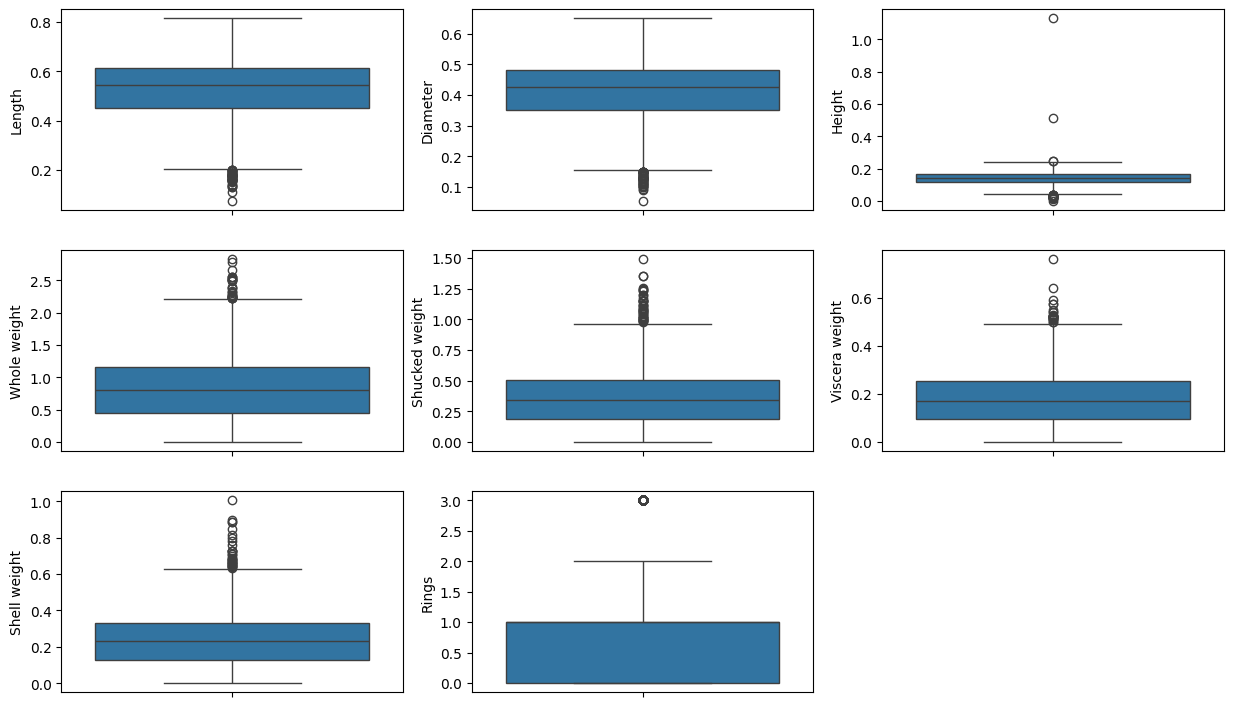

In [68]:
fig = plt.figure(figsize=(15,12))
pos = 1
for i in df.columns:
  if(type(df[i][0]) != str):
    plt.subplot(4,3,pos)
    sns.boxplot(df[i])
    pos+=1

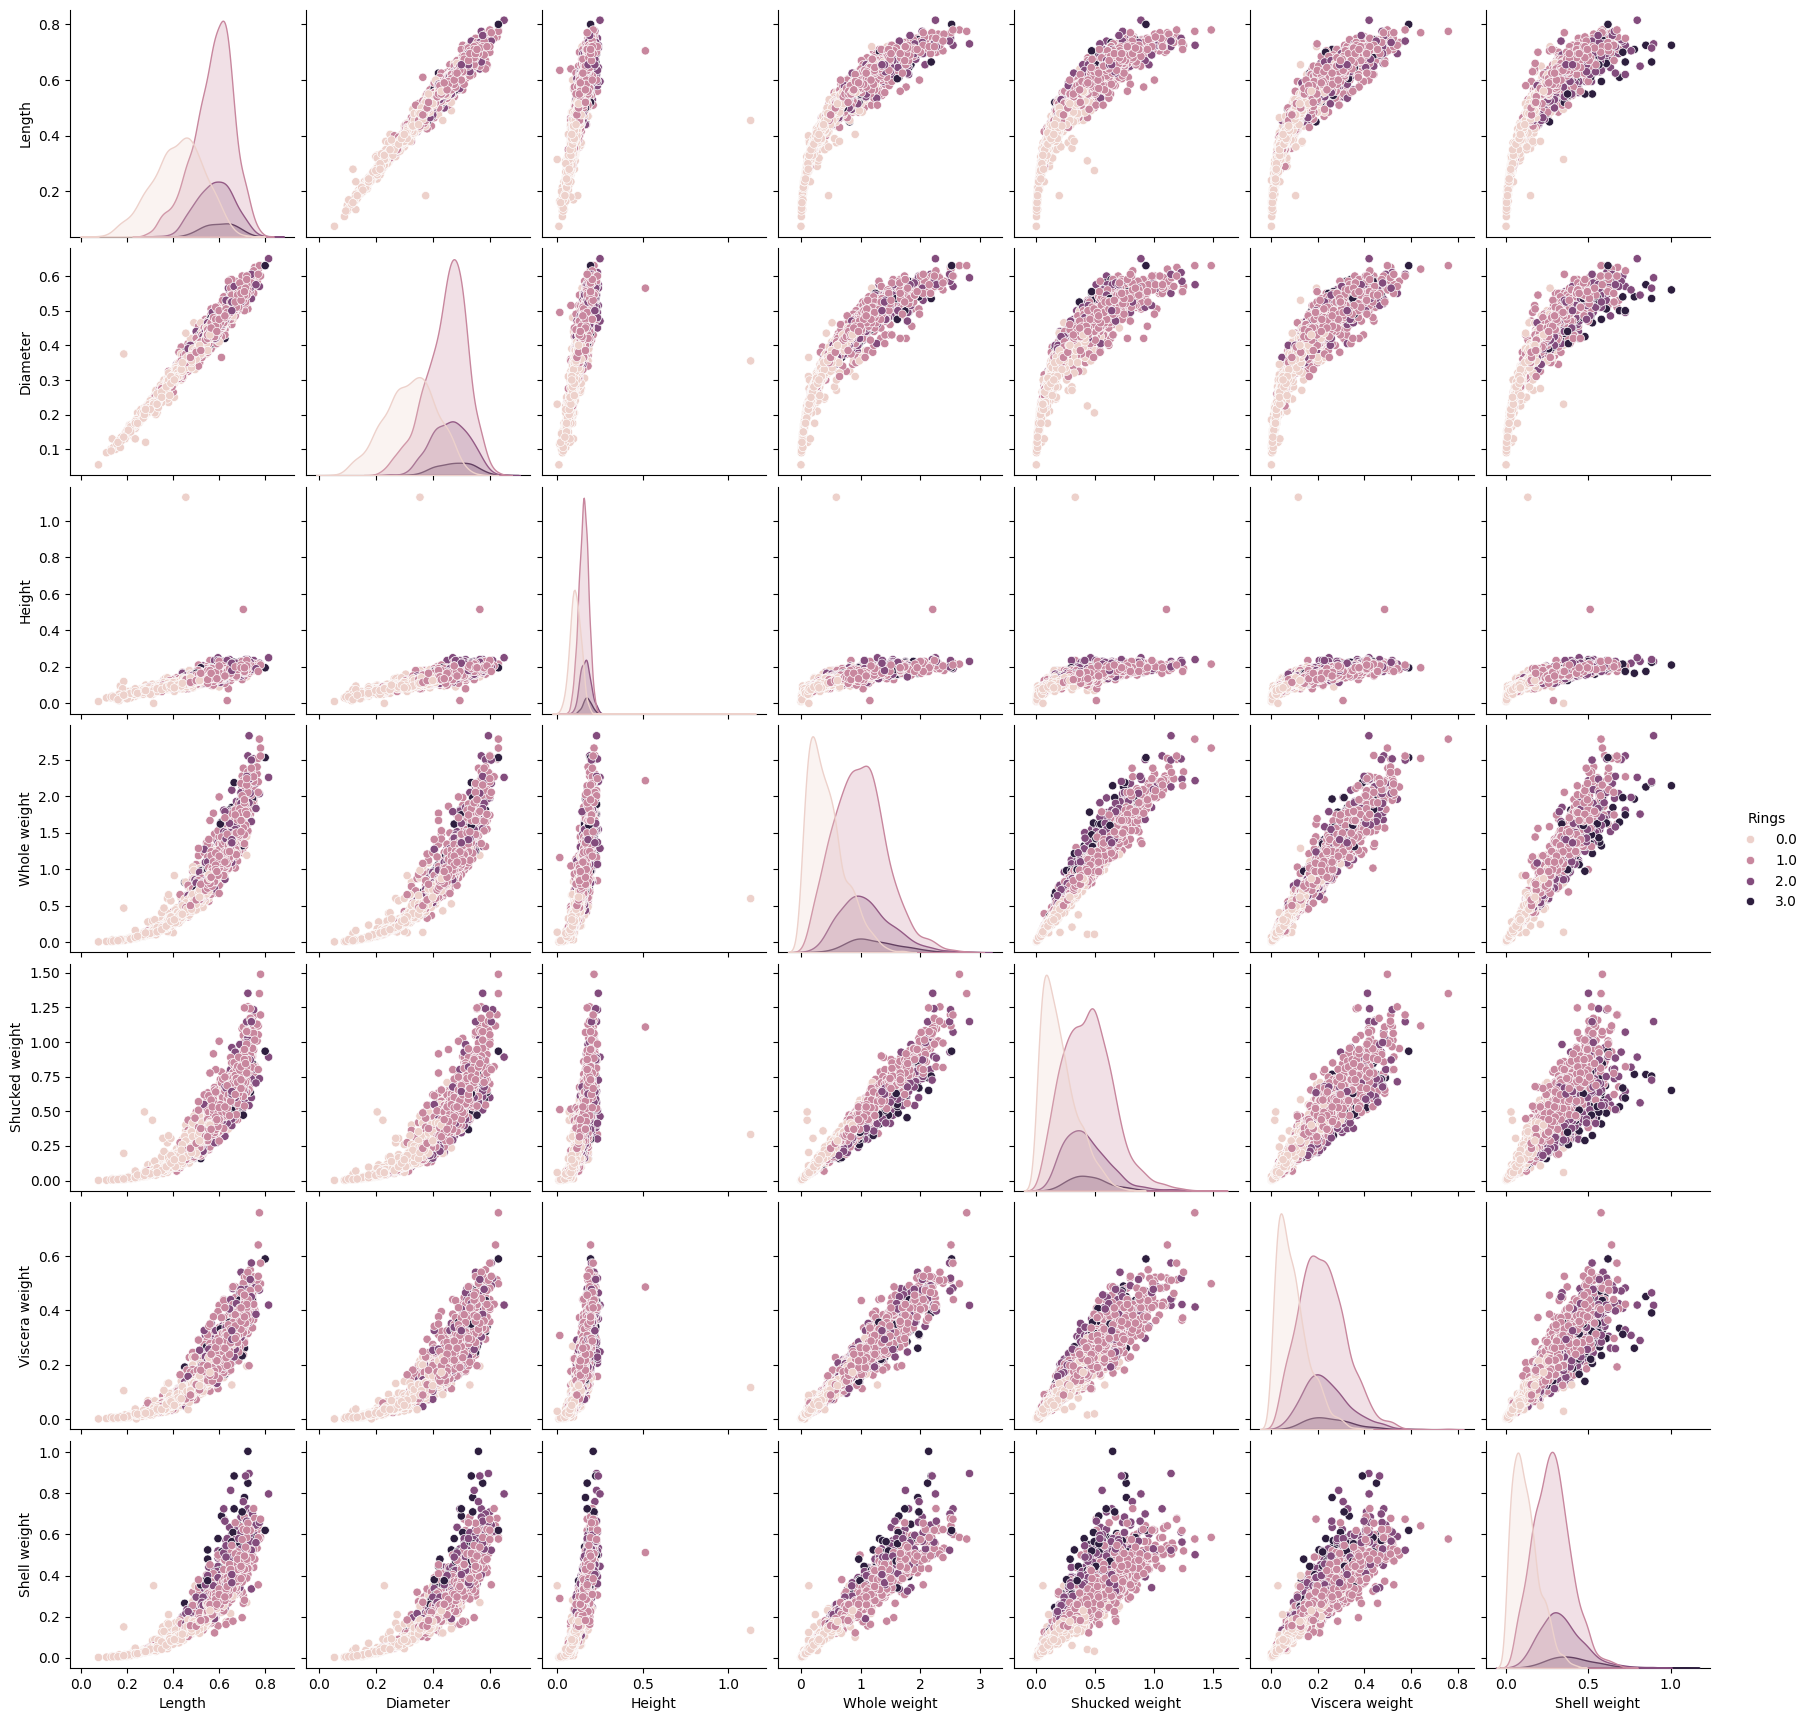

In [69]:
sns.pairplot(df, hue=target)

##2. Comment the exploration of step 1 pointing out if there are imbalanced distributions, outliers, missing values (2pt)


In [70]:
print('There are {} missing/NaN values'.format(df.isna().any(axis=1).sum()))

There are 1125 missing/NaN values


Few outliers are present for every attribute and along all classes. Median values are stable and happen to be in the middle of the distribution of most attributes. There is no particular imbalanced distribution. There are 1125 missing values.

##3. Drop the columns that are not relevant for the classification operation, if any, and explain why you do that. Deal with missing values, if any (4pt)


<ipython-input-71-0b2dcc63be37>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

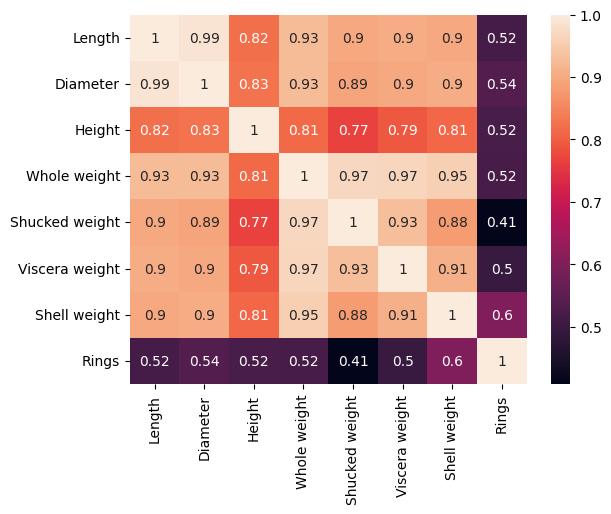

In [71]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)

In [75]:
df = df.dropna()
df = df.drop('Sex', axis=1)
print('The cleaned dataset has the following shape: {}'.format(df.shape))

The cleaned dataset has the following shape: (3052, 8)


##4. Find the best classification scheme considering two classification methods, find the best hyperparameters using cross validation; the optimization must be focused on the f1_macro measure (4pt)


In [76]:
X = df.drop(target, axis=1).copy()
y = df[target]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state, train_size=train_size)

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

gs_results = pd.DataFrame()
gs_results = pd.DataFrame(columns=['name', 'best_params', 'accuracy'])

model_libs = ['dt', 'knn']
predictions = []

dt_param_grid = [{'random_state' : [random_state], 'max_depth' : list(np.arange(1,20))}]
knn_param_grid = [{'n_neighbors' : list(np.arange(1,20))}]

model_params = {'dt' : {'name' : 'Decision Tree'
                        , 'estimator' : DecisionTreeClassifier()
                        , 'param_grid' : dt_param_grid
                       },
                'knn' : {'name' : 'K-Nearest Neighbors'
                        , 'estimator' : KNeighborsClassifier()
                        , 'param_grid' : knn_param_grid
                       }
                }

for m in model_libs:
  print('-'*40)
  print('Tuning {}'.format(model_params[m]['name']))
  gs = GridSearchCV(model_params[m]['estimator']
                    , model_params[m]['param_grid']
                    , refit=True
                    , scoring='f1_macro')
  gs.fit(Xtrain, ytrain)
  y_gs = gs.predict(Xtest)
  gs_results.loc[len(gs_results)] = {'name' : model_params[m]['name']
                                      , 'best_params' : gs.best_params_
                                      , 'accuracy' : accuracy_score(ytest, y_gs) * 100}
  predictions.append(y_gs)

----------------------------------------
Tuning Decision Tree
----------------------------------------
Tuning K-Nearest Neighbors


##5. Show the performance measures and the confusion matrices for the best hyperparameters of each model (2pt)


In [102]:
for index, row in gs_results.iterrows():
    print('-' * 40)
    print('{} - best parameters: {}\taccuracy: {:.2f}%\n'.format(row['name'], row['best_params'], row['accuracy']))
    print(classification_report(ytest, predictions[index]))
    cm = confusion_matrix(ytest, predictions[index])
    print('Confusion matrix:')
    print(cm)

----------------------------------------
Decision Tree - best parameters: {'max_depth': 9, 'random_state': 42}	accuracy: 62.70%

              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70       297
         1.0       0.63      0.76      0.69       485
         2.0       0.46      0.35      0.39       190
         3.0       0.00      0.00      0.00        36

    accuracy                           0.63      1008
   macro avg       0.45      0.44      0.45      1008
weighted avg       0.61      0.63      0.61      1008

Confusion matrix:
[[199  92   6   0]
 [ 60 367  56   2]
 [ 10 107  66   7]
 [  2  17  17   0]]
----------------------------------------
K-Nearest Neighbors - best parameters: {'n_neighbors': 1}	accuracy: 56.35%

              precision    recall  f1-score   support

         0.0       0.62      0.68      0.65       297
         1.0       0.60      0.59      0.60       485
         2.0       0.41      0.41      0.41       190
       

##6. Comment the results (2pt)

Results are similar with both classifiers, accuracy is not optimal. From the confusion matrix and from other performance measures, it's clear that these classifiers struggled with class 2 and 3. From the initial pairplot we could see that the dataset wasn't great to begin with. But performance obtained isn't great, but ok.